In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
from matplotlib.collections import PolyCollection
import math
import seaborn as sns

In [111]:
np.random.seed(47)

# Hierarchical model without covariates

In [112]:
# load data

# Read in the CSV file
s1 = pd.read_csv('Scores_without_covariates', sep = ' ')
print(s1.groupby("school")["mathscore"].count())

# Get the number of rows in the dataframe
n_rows = s1.shape[0]

# Print the number of rows
print(f'Number of rows: {n_rows}')

school
1      31
2      22
3      23
4      19
5      21
       ..
96     21
97     27
98     31
99     24
100    30
Name: mathscore, Length: 100, dtype: int64
Number of rows: 1993


In [229]:
m = len(np.unique(s1['school']))

In [113]:
def posterior_without_covariates(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin):
    # starting values
    m = len(np.unique(s1['school']))
    Y = s1['mathscore']
    aggs = s1.groupby(s1['school'])['mathscore'].agg(['mean', 'var', 'count'])
    ybar = np.array(aggs['mean'])
    sv = np.array(aggs['var'])
    n = np.array(aggs['count'])
    eta_m = (eta0 + m)
    nu_n = (nu0 + np.sum(n))
    
    #Initial values
    mu = np.random.normal(mu0, np.sqrt(g2_0))
    tau2 = 1/np.random.gamma(shape = eta0/2, scale = 1/(eta0*t2_0/2))
    sigma2 = 1/np.random.gamma(shape = nu0/2, scale = 1/(nu0*s2_0/2))
    
    #burn-in iterations
    for i in range(burnin_it):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
    #actual iterations
    chain_theta = np.zeros((it_after_burnin, m))
    chain_SMT = np.zeros((it_after_burnin, 3))
    for i in range(it_after_burnin):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
        #Save updates
        chain_theta[i,:] = theta
        chain_SMT[i,:] = (sigma2, mu, tau2)
        
    return chain_theta, chain_SMT
    

In [114]:
nu0 = 1
s2_0 = 100
eta0 = 1
t2_0 = 100
mu0 = 50
g2_0 = 25
burnin_it = 5000
it_after_burnin = 5000
chain_theta, chain_SMT = posterior_without_covariates(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin)

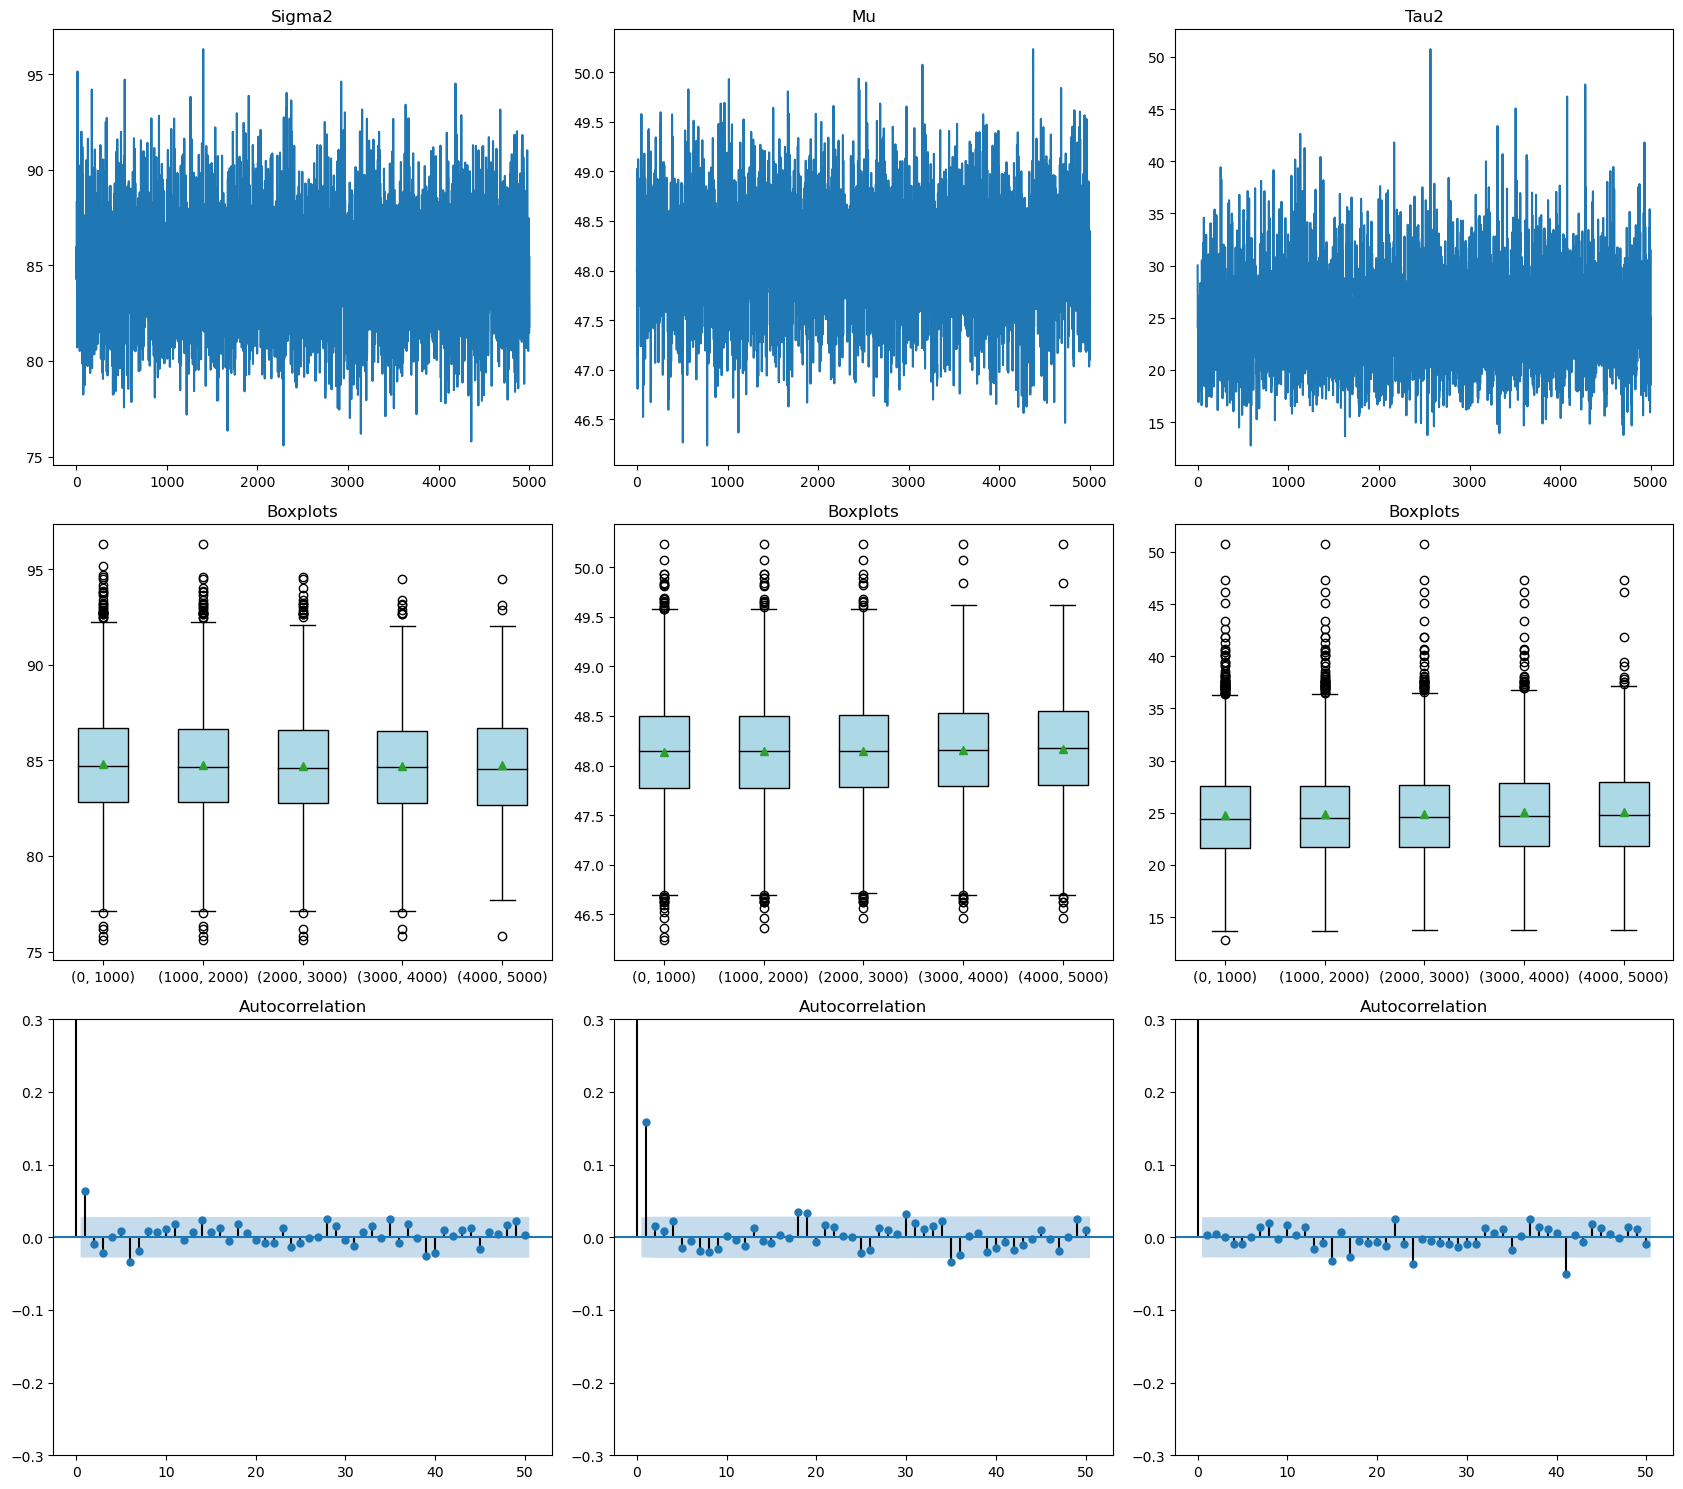

In [115]:
# trace plot 
fig, ax = plt.subplots(3,3, figsize = (17, 15))

# Extract the values of the variables from the Markov chain
sigma_values = [x[0] for x in chain_SMT]
mu_values = [x[1] for x in chain_SMT]
tau_values = [x[2] for x in chain_SMT]
theta_values = [x[0] for x in chain_theta]

ax[0,0].title.set_text('Sigma2')
ax[0,1].title.set_text('Mu')
ax[0,2].title.set_text('Tau2')

ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')

ax[1,0].boxplot(np.array([sigma_values[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([mu_values[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([tau_values[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightblue'), showmeans=True, medianprops = dict(color="black")) 

# Plot the values of the sigma variable at each iteration
ax[0,0].plot(sigma_values)

# Plot the values of the mu variable at each iteration
ax[0,1].plot(mu_values)

# Plot the values of the tau variable at each iteration
ax[0,2].plot(tau_values)

ACF_sigma = plot_acf(sigma_values, lags = 50, ax = ax[2,0])
ACF_mu = plot_acf(mu_values, lags = 50, ax = ax[2,1])
ACF_theta = plot_acf(theta_values,  lags = 50, ax = ax[2,2])

ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])

fig.tight_layout()
fig.savefig('Chain0.pdf')

In [125]:
nu0 = 1
s2_0 = 60
eta0 = 1
t2_0 = 60
mu0 = 50
g2_0 = 100
burnin_it = 5000
it_after_burnin = 5000
chain_theta_1, chain_SMT_1 = posterior_without_covariates(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin)

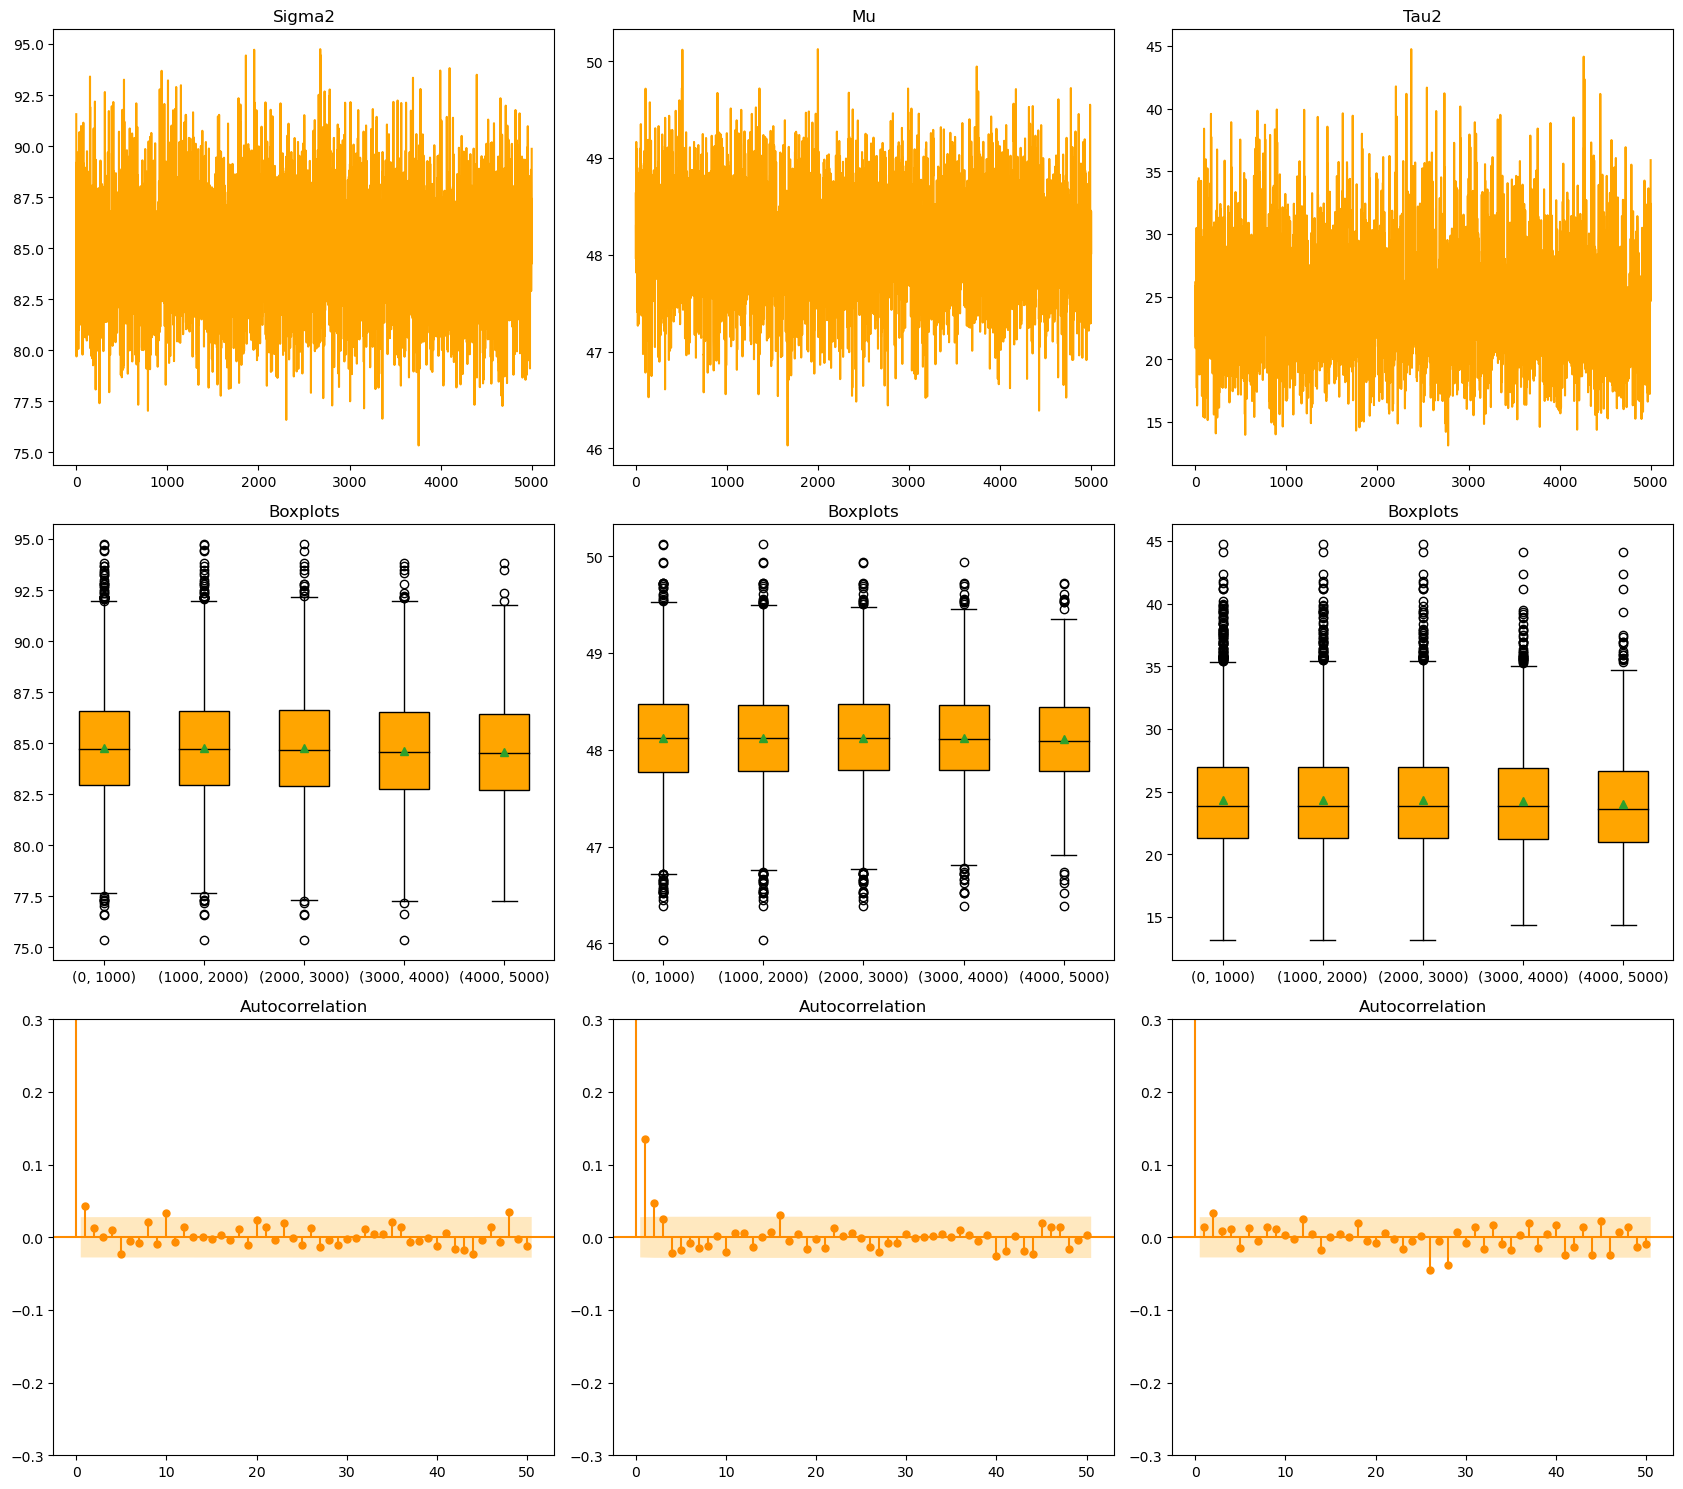

In [127]:
# trace plot 
fig, ax = plt.subplots(3,3, figsize = (17,15))

# Extract the values of the variables from the Markov chain
sigma_values_1 = [x[0] for x in chain_SMT_1]
mu_values_1 = [x[1] for x in chain_SMT_1]
tau_values_1 = [x[2] for x in chain_SMT_1]
theta_values_1 = [x[0] for x in chain_theta_1]


ax[0,0].title.set_text('Sigma2')
ax[0,1].title.set_text('Mu')
ax[0,2].title.set_text('Tau2')

ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')

# Plot the values of the sigma variable at each iteration
ax[0,0].plot(sigma_values_1, 'orange')

# Plot the values of the mu variable at each iteration
ax[0,1].plot(mu_values_1, 'orange')

# Plot the values of the tau variable at each iteration
ax[0,2].plot(tau_values_1, 'orange')

ax[1,0].boxplot(np.array([sigma_values_1[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([mu_values_1[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([tau_values_1[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='orange'), showmeans=True, medianprops = dict(color="black")) 

ACF_sigma = plot_acf(sigma_values_1, lags = 50, ax = ax[2,0], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ACF_mu = plot_acf(mu_values_1, lags = 50, ax = ax[2,1], color='darkorange', vlines_kwargs={"colors": 'darkorange'})
ACF_theta = plot_acf(theta_values_1,  lags = 50, ax = ax[2,2], color='darkorange', vlines_kwargs={"colors": 'darkorange'})

ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])

for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('orange')

fig.tight_layout()
fig.savefig('Chain1.pdf')

In [118]:
def posterior_without_covariates_2(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin):
    # starting values
    m = len(np.unique(s1['school']))
    Y = s1['mathscore']
    aggs = s1.groupby(s1['school'])['mathscore'].agg(['mean', 'var', 'count'])
    ybar = np.array(aggs['mean'])
    sv = np.array(aggs['var'])
    n = np.array(aggs['count'])
    eta_m = (eta0 + m)
    nu_n = (nu0 + np.sum(n))
    
    #Initial values
    mu = mu0
    tau2 = t2_0
    sigma2 = s2_0
    
    #burn-in iterations
    for i in range(burnin_it):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
    #actual iterations
    chain_theta = np.zeros((it_after_burnin, m))
    chain_SMT = np.zeros((it_after_burnin, 3))
    for i in range(it_after_burnin):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
        #Save updates
        chain_theta[i,:] = theta
        chain_SMT[i,:] = (sigma2, mu, tau2)
        
    return chain_theta, chain_SMT
    

In [119]:
nu0 = 1
s2_0 = 100
eta0 = 1
t2_0 = 100
mu0 = 50
g2_0 = 25
burnin_it = 5000
it_after_burnin = 5000
chain_theta_2, chain_SMT_2 = posterior_without_covariates_2(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin)

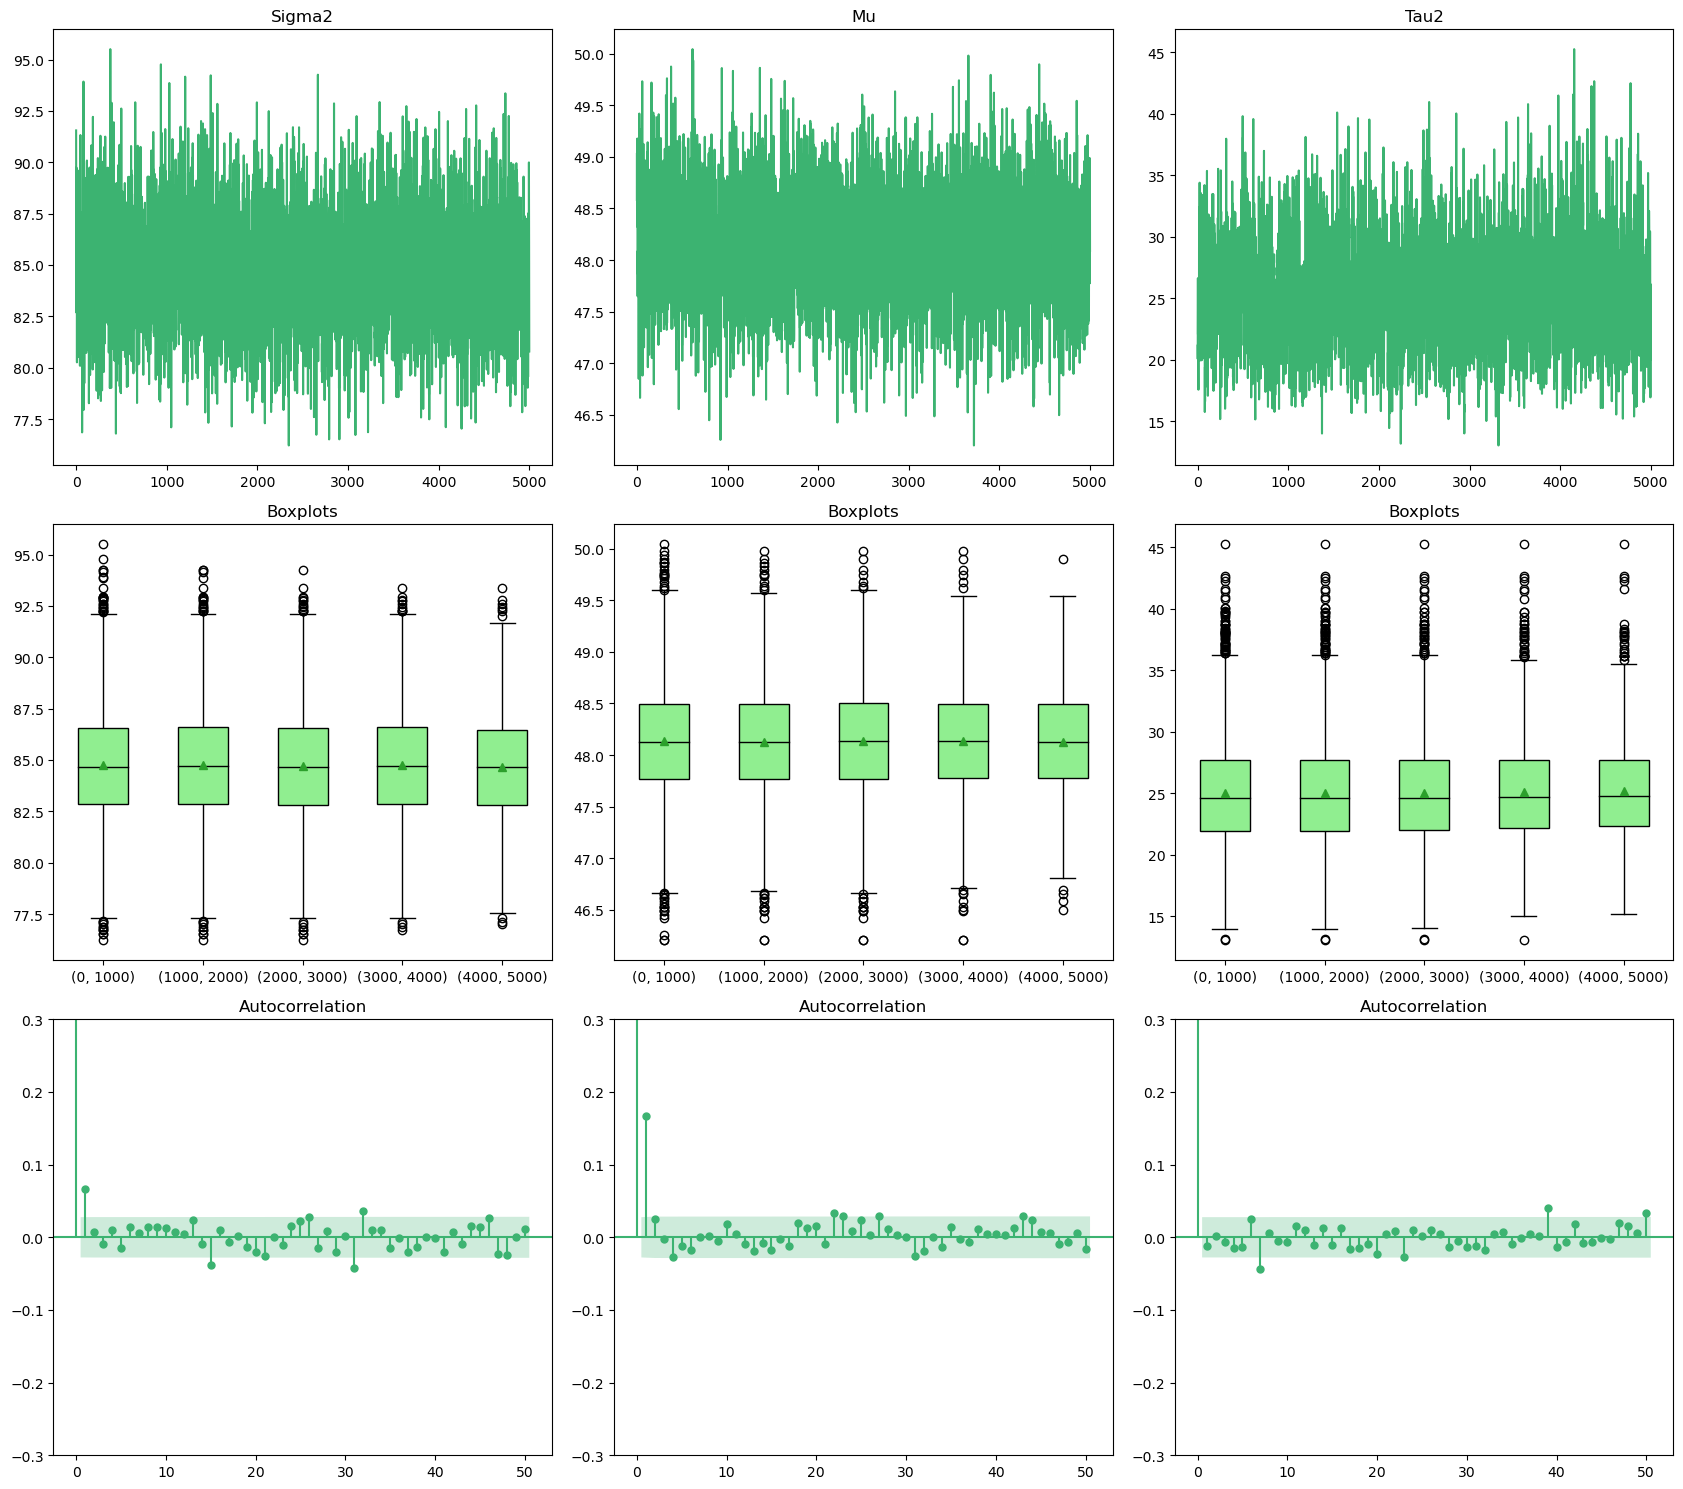

In [142]:
# trace plot 
fig, ax = plt.subplots(3,3, figsize = (17,15))

# Extract the values of the variables from the Markov chain
sigma_values_2 = [x[0] for x in chain_SMT_2]
mu_values_2 = [x[1] for x in chain_SMT_2]
tau_values_2 = [x[2] for x in chain_SMT_2]
theta_values_2 = [x[0] for x in chain_theta_2]


ax[0,0].title.set_text('Sigma2')
ax[0,1].title.set_text('Mu')
ax[0,2].title.set_text('Tau2')

ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')

# Plot the values of the sigma variable at each iteration
ax[0,0].plot(sigma_values_2, 'mediumseagreen')

# Plot the values of the mu variable at each iteration
ax[0,1].plot(mu_values_2, 'mediumseagreen')

# Plot the values of the tau variable at each iteration
ax[0,2].plot(tau_values_2, 'mediumseagreen')

ax[1,0].boxplot(np.array([sigma_values_2[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([mu_values_2[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([tau_values_2[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='lightgreen'), showmeans=True, medianprops = dict(color="black")) 

ACF_sigma = plot_acf(sigma_values_2, lags = 50, ax = ax[2,0], color= 'mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ACF_mu = plot_acf(mu_values_2, lags = 50, ax = ax[2,1], color= 'mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})
ACF_theta = plot_acf(theta_values_2,  lags = 50, ax = ax[2,2], color= 'mediumseagreen', vlines_kwargs={"colors": 'mediumseagreen'})

ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])

for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumseagreen')

fig.tight_layout()
fig.savefig('Chain2.pdf')

In [121]:
def posterior_without_covariates_3(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin):
    # starting values
    m = len(np.unique(s1['school']))
    Y = s1['mathscore']
    aggs = s1.groupby(s1['school'])['mathscore'].agg(['mean', 'var', 'count'])
    ybar = np.array(aggs['mean'])
    sv = np.array(aggs['var'])
    n = np.array(aggs['count'])
    eta_m = (eta0 + m)
    nu_n = (nu0 + np.sum(n))
    
    #Initial values
    mu = 0
    tau2 = 1
    sigma2 = 1
    
    #burn-in iterations
    for i in range(burnin_it):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
    #actual iterations
    chain_theta = np.zeros((it_after_burnin, m))
    chain_SMT = np.zeros((it_after_burnin, 3))
    for i in range(it_after_burnin):
        #Update theta
        theta = np.zeros(m)
        for j in range(m):
            v_theta = 1/(n[j]/sigma2 + 1/tau2)
            e_theta = v_theta*(n[j]*ybar[j]/sigma2 + mu/tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))
        #Update mu
        v_mu = 1/(m/tau2 + 1/g2_0)
        e_mu = v_mu * (m*np.mean(theta) / tau2 + mu0/g2_0)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))
        #Update tau
        ss_m = eta0 * t2_0 + np.sum((theta - mu)**2)
        tau2 = 1/np.random.gamma(eta_m/2, 1/(ss_m/2))
        #Update sigma2
        ss_n = nu0*s2_0
        for j in range(m):
            ss_n += np.sum((np.array(s1[s1['school'] == j+1]['mathscore']) - theta[j])**2) 
        sigma2 = 1/np.random.gamma(nu_n/2, 1/(ss_n/2))
        
        #Save updates
        chain_theta[i,:] = theta
        chain_SMT[i,:] = (sigma2, mu, tau2)
        
    return chain_theta, chain_SMT
    

In [122]:
nu0 = 1
s2_0 = 100
eta0 = 1
t2_0 = 100
mu0 = 50
g2_0 = 25
burnin_it = 5000
it_after_burnin = 5000
chain_theta_3, chain_SMT_3 = posterior_without_covariates_3(s1, nu0, s2_0, eta0, t2_0, mu0, g2_0, burnin_it, it_after_burnin)

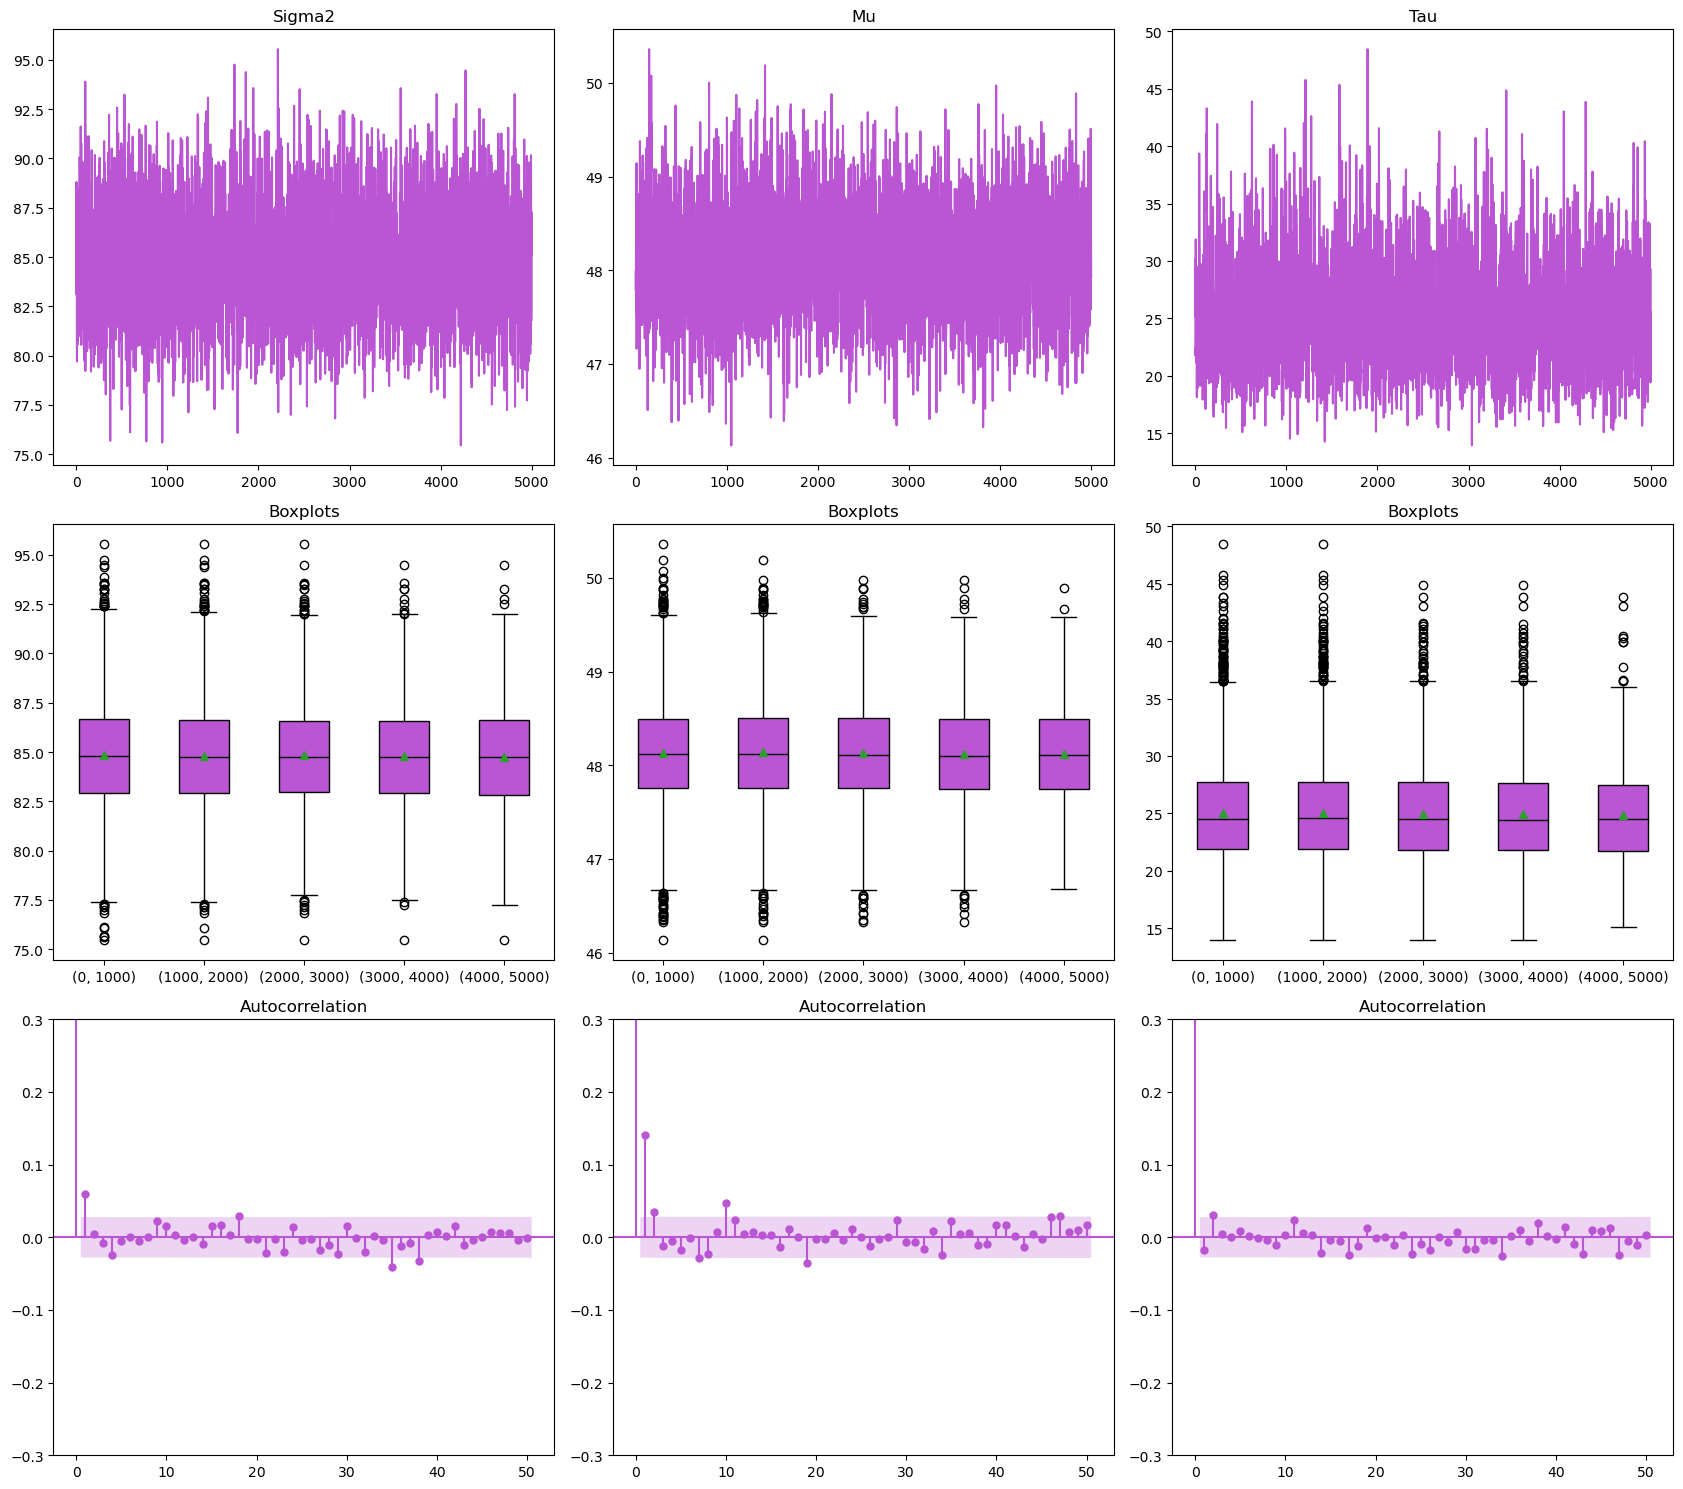

In [123]:
# trace plot 
fig, ax = plt.subplots(3,3, figsize = (17,15))

# Extract the values of the variables from the Markov chain
sigma_values_3 = [x[0] for x in chain_SMT_3]
mu_values_3 = [x[1] for x in chain_SMT_3]
tau_values_3 = [x[2] for x in chain_SMT_3]
theta_values_3 = [x[0] for x in chain_theta_3]


ax[0,0].title.set_text('Sigma2')
ax[0,1].title.set_text('Mu')
ax[0,2].title.set_text('Tau')

ax[1,0].title.set_text('Boxplots')
ax[1,1].title.set_text('Boxplots')
ax[1,2].title.set_text('Boxplots')

# Plot the values of the sigma variable at each iteration
ax[0,0].plot(sigma_values_3, 'mediumorchid')

# Plot the values of the mu variable at each iteration
ax[0,1].plot(mu_values_3, 'mediumorchid')

# Plot the values of the tau variable at each iteration
ax[0,2].plot(tau_values_3, 'mediumorchid')

ax[1,0].boxplot(np.array([sigma_values_3[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,1].boxplot(np.array([mu_values_3[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 
ax[1,2].boxplot(np.array([tau_values_3[k:] for k in range(0,5000,1000)], dtype = list),
                vert=True, labels = [(0,1000), (1000,2000), (2000,3000), (3000,4000), (4000,5000)],  
                patch_artist=True, boxprops=dict(facecolor='mediumorchid'), showmeans=True, medianprops = dict(color="black")) 

ACF_sigma = plot_acf(sigma_values_3, lags = 50, ax = ax[2,0], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ACF_mu = plot_acf(mu_values_3, lags = 50, ax = ax[2,1], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})
ACF_theta = plot_acf(theta_values_3,  lags = 50, ax = ax[2,2], color= 'mediumorchid', vlines_kwargs={"colors": 'mediumorchid'})

ax[2,0].set_ylim([-0.3, 0.3])
ax[2,1].set_ylim([-0.3, 0.3])
ax[2,2].set_ylim([-0.3, 0.3])

for item in ax[2,0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')
for item in ax[2,1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')
for item in ax[2,2].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('mediumorchid')

fig.tight_layout()
fig.savefig('Chain3.pdf')

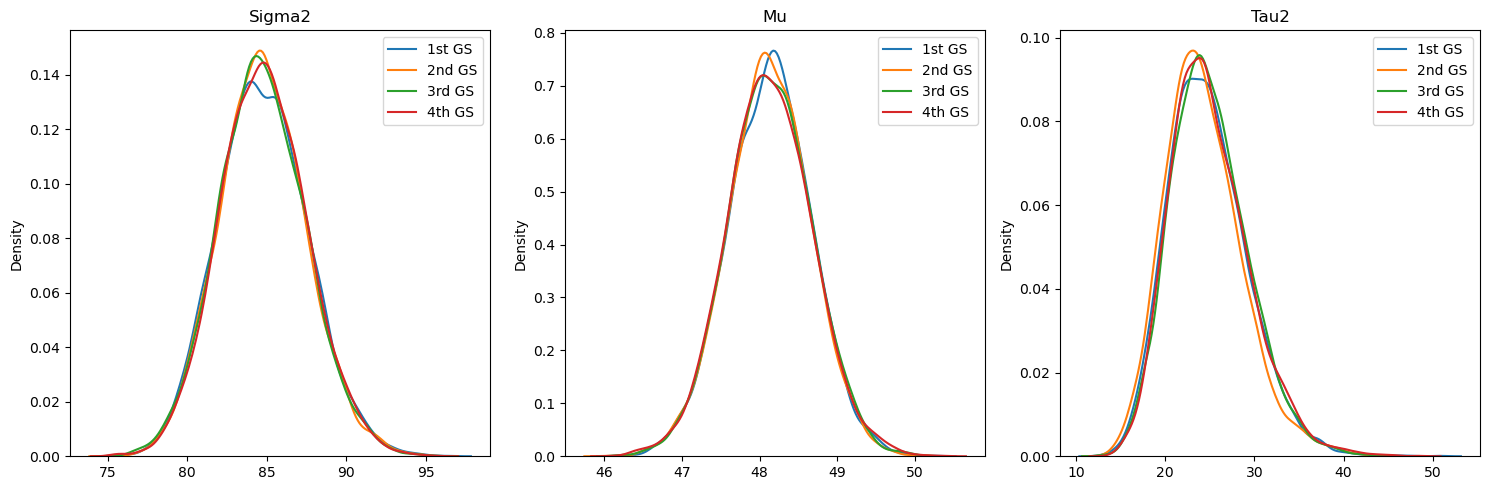

In [128]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(sigma_values, ax = ax[0], label = '1st GS')
sns.kdeplot(sigma_values_1, ax = ax[0], label = '2nd GS')
sns.kdeplot(sigma_values_2, ax = ax[0], label = '3rd GS')
sns.kdeplot(sigma_values_3, ax = ax[0], label = '4th GS')
ax[0].legend()
ax[0].title.set_text('Sigma2')
ax[1].title.set_text('Mu')
ax[2].title.set_text('Tau2')
sns.kdeplot(mu_values, ax = ax[1], label = '1st GS')
sns.kdeplot(mu_values_1, ax = ax[1], label = '2nd GS')
sns.kdeplot(mu_values_2, ax = ax[1], label = '3rd GS')
sns.kdeplot(mu_values_3, ax = ax[1], label = '4th GS')
ax[1].legend()
sns.kdeplot(tau_values, ax = ax[2], label = '1st GS')
sns.kdeplot(tau_values_1, ax = ax[2], label = '2nd GS')
sns.kdeplot(tau_values_2, ax = ax[2], label = '3rd GS')
sns.kdeplot(tau_values_3, ax = ax[2], label = '4th GS')
ax[2].legend()
fig.tight_layout()
fig.savefig('Comp2-SMT.pdf')

In [204]:
nj = np.array(s1.groupby('school').count())

In [205]:
yj = np.array(s1.groupby('school').mean())

In [372]:
theta = chain_theta.mean(axis = 0).reshape((100,1))

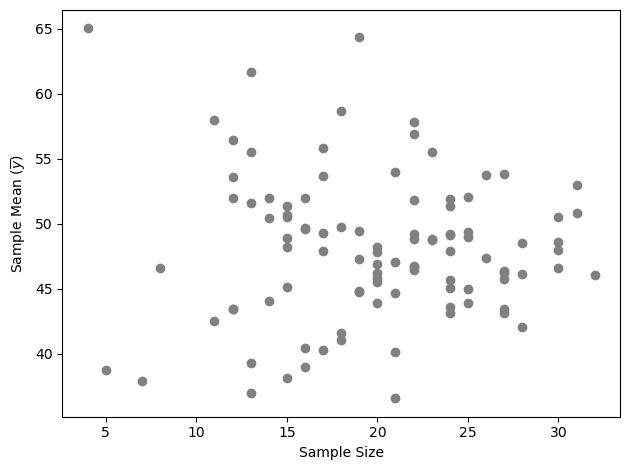

In [218]:
plt.scatter(nj, yj, color = 'grey')
plt.ylabel('Sample Mean ($\overline{y} $)')
plt.xlabel('Sample Size')
plt.tight_layout()
plt.savefig('SampleMeanSampleSize.pdf')

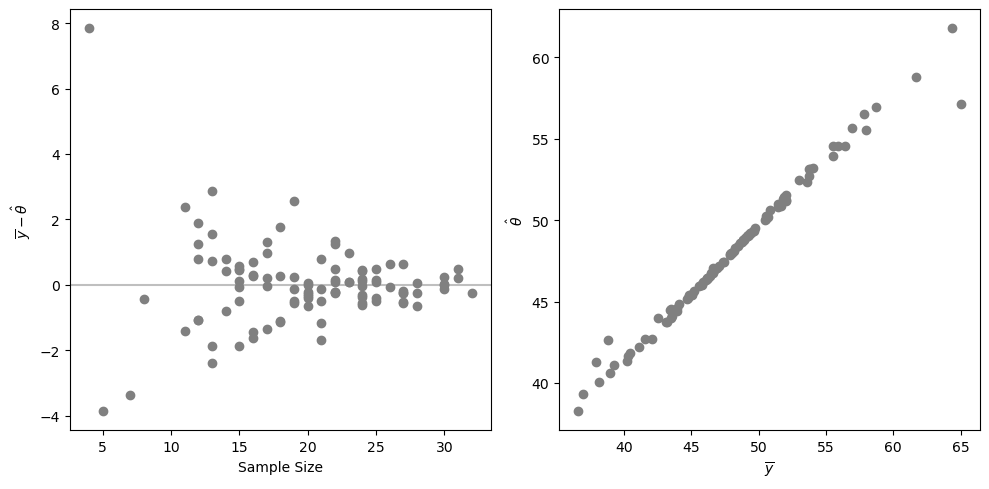

In [207]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
diff = yj - theta
ax[0].scatter(x = nj, y = diff, marker = 'o', color = 'gray')
ax[0].axhline(y=0, color='grey', linestyle='-', alpha = 0.5)
ax[0].set_ylabel('$\overline {y} - \hat θ $')
ax[0].set_xlabel('Sample Size')
ax[1].scatter(x = yj, y = theta, marker = 'o', color = 'gray')
ax[1].set_ylabel('$\hat θ $')
ax[1].set_xlabel('$\overline {y}$')
plt.tight_layout()
plt.savefig('Shrinkage.pdf')

In [243]:
sigma2_exp = (chain_SMT[:,0]).mean()
sigma2_exp

84.78872867552177

In [246]:
#95% confidence interval sigma2
np.quantile(chain_SMT[:,0], (0.025, 0.975))

array([79.55062027, 90.5391733 ])

In [245]:
mu_exp = (chain_SMT[:,1]).mean()
mu_exp

48.13795974241672

In [249]:
#95% confidence interval mu
np.quantile(chain_SMT[:,1], (0.025, 0.975))

array([47.07026264, 49.17976887])

In [244]:
tau2_exp = (chain_SMT[:,2]).mean()
tau2_exp

24.800607726340715

In [248]:
#95% confidence interval tau2
np.quantile(chain_SMT[:,2], (0.025, 0.975))

array([17.38924004, 34.4143702 ])

In [373]:
theta.min(), theta.max()

(38.260025617640764, 61.79966805778787)

In [374]:
theta.argmin() + 1, theta.argmax() + 1

(5, 51)

In [375]:
theta_sorted = theta.copy()
arg = theta_sorted.argsort(axis = 0) + 1 
d = {}
for j in range(m):
    d[j+1] = float(theta[j])

In [376]:
d_sorted = dict(sorted(d.items(), key=lambda item: item[1]))
d_sorted

{5: 38.260025617640764,
 72: 39.32659658619898,
 49: 40.032732363909766,
 6: 40.59129802649131,
 78: 41.12652934209993,
 17: 41.30095903339081,
 46: 41.35377876931109,
 74: 41.66129394796945,
 7: 41.86318469375953,
 10: 42.2194108528536,
 82: 42.631159295905576,
 50: 42.67588252110099,
 60: 42.695230063651515,
 64: 43.720631761072966,
 55: 43.73478196746671,
 53: 43.96955541486158,
 70: 44.01059733392402,
 84: 44.1289526640097,
 57: 44.43227810960063,
 19: 44.491175842285024,
 27: 44.532612675448114,
 47: 44.57643600529777,
 83: 44.861733756086615,
 77: 45.18197312230363,
 68: 45.2445165637241,
 25: 45.38580470787235,
 95: 45.42929800587496,
 61: 45.43692433840811,
 45: 45.66073982316102,
 24: 45.94548680843423,
 97: 45.995731135723126,
 34: 46.00653135573905,
 20: 46.206601506328155,
 37: 46.318810045847606,
 42: 46.39676816311357,
 39: 46.442617201511865,
 29: 46.4703825421699,
 54: 46.556678333032195,
 26: 46.733816006816134,
 2: 46.73385713146091,
 71: 46.91401187338502,
 48: 47.01

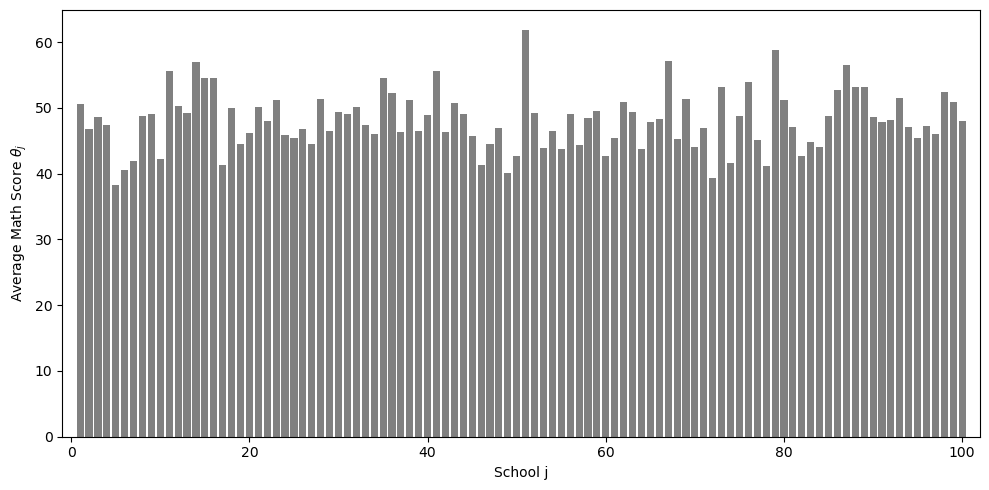

In [383]:
plt.figure(figsize = (10,5))
plt.bar(d_sorted.keys(), d_sorted.values(), color = 'grey')
plt.tight_layout()
plt.ylabel('Average Math Score $θ_j$')
plt.xlabel('School j')
plt.xlim(-1,102)
plt.tight_layout()
plt.savefig('Ranking.pdf')